# Examining variables with high correlation to increase accuracy and analyze feature importance

## Pre-process data

#### For now, we will look only at continuous values, and then add in our categorical values

In [108]:
#Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [109]:
from sklearn.model_selection import train_test_split 
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from math import sqrt

In [110]:
#Import data and analyze
data = r'/Users/OliverPan/Desktop/house/train.csv'

In [111]:
df = pd.read_csv(data)

In [112]:
high_corr = df.corr()["SalePrice"].to_frame().sort_values(by=["SalePrice"])
high_corr = high_corr[high_corr["SalePrice"] > 0.6]
high_corr

,SalePrice
1stFlrSF,0.605852
TotalBsmtSF,0.613581
GarageArea,0.623431
GarageCars,0.640409
GrLivArea,0.708624
OverallQual,0.790982
SalePrice,1.000000


In [113]:
#Take high correlation (above 0.6) into model
corr_df = df[["Id", "SalePrice", "OverallQual","GrLivArea","GarageCars", "GarageArea", "1stFlrSF", "SaleCondition", "LotArea", "BsmtQual", "TotalBsmtSF", "HeatingQC", "FireplaceQu"]]

### Basic Analysis

#### It seems that the garage and square feet are highly correlated to SalePrice

In [114]:
corr_df.head()

,Id,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,SaleCondition,LotArea,BsmtQual,TotalBsmtSF,HeatingQC,FireplaceQu
0,1,208500,7,1710,2,548,856,Normal,8450,Gd,856,Ex,NaN
1,2,181500,6,1262,2,460,1262,Normal,9600,Gd,1262,Ex,TA
2,3,223500,7,1786,2,608,920,Normal,11250,Gd,920,Ex,TA
3,4,140000,7,1717,3,642,961,Abnorml,9550,TA,756,Gd,Gd
4,5,250000,8,2198,3,836,1145,Normal,14260,Gd,1145,Ex,TA


#### OverallQual is the highest correlated variable

In [115]:
corr_df["OverallQual"].value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

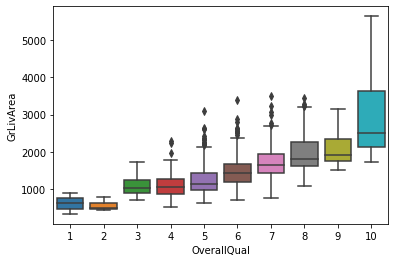

In [116]:
sns.boxplot(y = corr_df["GrLivArea"], x = corr_df["OverallQual"])

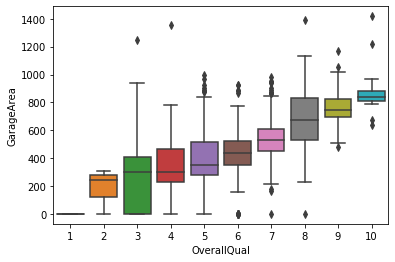

In [117]:
sns.boxplot(y = corr_df["GarageArea"], x = corr_df["OverallQual"])

### Analyse Categorical Values
#### Looking at Categorical values that may have higher correlation to SalePrice

In [118]:
categorical = df[["Id", "SalePrice", "Street", "Alley", "LandSlope", "ExterQual", "SaleCondition", "BsmtQual", "HeatingQC", "FireplaceQu"]]
categorical["Street"] = categorical["Street"].astype('category').cat.codes
categorical["Alley"] = categorical["Alley"].astype('category').cat.codes
categorical["LandSlope"] = categorical["LandSlope"].astype('category').cat.codes
categorical["ExterQual"] = categorical["ExterQual"].astype('category').cat.codes
categorical["SaleCondition"] = categorical["SaleCondition"].astype('category').cat.codes
categorical["BsmtQual"] = categorical["BsmtQual"].astype('category').cat.codes
categorical["HeatingQC"] = categorical["HeatingQC"].astype('category').cat.codes
categorical["FireplaceQu"] = categorical["FireplaceQu"].astype('category').cat.codes

categorical.head()

/Users/OliverPan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/OliverPan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/OliverPan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,Id,SalePrice,Street,Alley,LandSlope,ExterQual,SaleCondition,BsmtQual,HeatingQC,FireplaceQu
0,1,208500,1,-1,0,2,4,2,0,-1
1,2,181500,1,-1,0,3,4,2,0,4
2,3,223500,1,-1,0,2,4,2,0,4
3,4,140000,1,-1,0,3,0,3,2,2
4,5,250000,1,-1,0,2,4,2,0,4


In [119]:
corr_df = corr_df.drop(["SaleCondition", "BsmtQual", "HeatingQC", "FireplaceQu"], axis = 1)

In [120]:
corr_df = pd.merge(corr_df, categorical, on = ["Id", "SalePrice"], how = "left").drop(["Id"], axis = 1)

In [121]:
corr_df.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,LotArea,TotalBsmtSF,Street,Alley,LandSlope,ExterQual,SaleCondition,BsmtQual,HeatingQC,FireplaceQu
0,208500,7,1710,2,548,856,8450,856,1,-1,0,2,4,2,0,-1
1,181500,6,1262,2,460,1262,9600,1262,1,-1,0,3,4,2,0,4
2,223500,7,1786,2,608,920,11250,920,1,-1,0,2,4,2,0,4
3,140000,7,1717,3,642,961,9550,756,1,-1,0,3,0,3,2,2
4,250000,8,2198,3,836,1145,14260,1145,1,-1,0,2,4,2,0,4


In [122]:
corr_df.corr()["SalePrice"]

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
1stFlrSF         0.605852
LotArea          0.263843
TotalBsmtSF      0.613581
Street           0.041036
Alley           -0.092607
LandSlope        0.051152
ExterQual       -0.636884
SaleCondition    0.213092
BsmtQual        -0.438881
HeatingQC       -0.400178
FireplaceQu      0.378377
Name: SalePrice, dtype: float64

### CatBoost

In [123]:
X = corr_df.drop(["SalePrice"], axis = 1)
y = corr_df[["SalePrice"]]

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

In [125]:
category = ["OverallQual", "GarageCars", "Street", "Alley", "LandSlope", "ExterQual", "SaleCondition", "BsmtQual", "HeatingQC", "FireplaceQu"]

In [126]:
cat_boost = CatBoostRegressor(depth=3, learning_rate=0.1, loss_function='RMSE')
cat_boost.fit(X_train, y_train, cat_features = category)

0:	learn: 74400.1991774	total: 3.55ms	remaining: 3.54s
1:	learn: 70699.3077225	total: 13.4ms	remaining: 6.68s
2:	learn: 66940.2841267	total: 15.5ms	remaining: 5.14s
3:	learn: 63621.6947034	total: 18.2ms	remaining: 4.52s
4:	learn: 60398.0689742	total: 21.9ms	remaining: 4.36s
5:	learn: 57811.5240622	total: 28.1ms	remaining: 4.65s
6:	learn: 55357.8766538	total: 29.9ms	remaining: 4.25s
7:	learn: 53206.1142239	total: 32.2ms	remaining: 3.99s
8:	learn: 51171.4625291	total: 34.2ms	remaining: 3.76s
9:	learn: 49396.2624342	total: 39ms	remaining: 3.86s
10:	learn: 47765.0527162	total: 42.7ms	remaining: 3.84s
11:	learn: 46289.2387312	total: 44.5ms	remaining: 3.67s
12:	learn: 44888.1477418	total: 46.5ms	remaining: 3.53s
13:	learn: 43544.5425940	total: 48.5ms	remaining: 3.42s
14:	learn: 42561.1135071	total: 56.5ms	remaining: 3.71s
15:	learn: 41451.6816966	total: 58.4ms	remaining: 3.59s
16:	learn: 40310.3504252	total: 60ms	remaining: 3.47s
17:	learn: 39586.7389628	total: 61.7ms	remaining: 3.37s
18:	le

173:	learn: 23201.7529542	total: 564ms	remaining: 2.68s
174:	learn: 23191.1566267	total: 567ms	remaining: 2.67s
175:	learn: 23166.4701419	total: 571ms	remaining: 2.67s
176:	learn: 23140.0381223	total: 575ms	remaining: 2.67s
177:	learn: 23127.6909662	total: 579ms	remaining: 2.67s
178:	learn: 23093.6528486	total: 583ms	remaining: 2.67s
179:	learn: 23060.4681160	total: 586ms	remaining: 2.67s
180:	learn: 23055.1112886	total: 588ms	remaining: 2.66s
181:	learn: 23051.3191797	total: 590ms	remaining: 2.65s
182:	learn: 23045.1952344	total: 592ms	remaining: 2.64s
183:	learn: 23036.2495768	total: 594ms	remaining: 2.63s
184:	learn: 22995.2207920	total: 596ms	remaining: 2.63s
185:	learn: 22962.2283533	total: 600ms	remaining: 2.62s
186:	learn: 22939.3745220	total: 602ms	remaining: 2.62s
187:	learn: 22881.5751347	total: 604ms	remaining: 2.61s
188:	learn: 22873.4230043	total: 606ms	remaining: 2.6s
189:	learn: 22846.0728782	total: 607ms	remaining: 2.59s
190:	learn: 22823.8993843	total: 610ms	remaining:

405:	learn: 19877.5526947	total: 1.11s	remaining: 1.63s
406:	learn: 19857.7584719	total: 1.12s	remaining: 1.63s
407:	learn: 19839.6826295	total: 1.12s	remaining: 1.63s
408:	learn: 19836.7261046	total: 1.12s	remaining: 1.62s
409:	learn: 19818.9012105	total: 1.13s	remaining: 1.62s
410:	learn: 19813.0095371	total: 1.13s	remaining: 1.62s
411:	learn: 19794.1574921	total: 1.14s	remaining: 1.62s
412:	learn: 19787.1281371	total: 1.14s	remaining: 1.62s
413:	learn: 19750.3143545	total: 1.14s	remaining: 1.62s
414:	learn: 19738.6969795	total: 1.15s	remaining: 1.62s
415:	learn: 19733.3000155	total: 1.15s	remaining: 1.61s
416:	learn: 19721.2668198	total: 1.15s	remaining: 1.61s
417:	learn: 19719.0242063	total: 1.16s	remaining: 1.61s
418:	learn: 19693.4072495	total: 1.16s	remaining: 1.61s
419:	learn: 19672.1655895	total: 1.16s	remaining: 1.6s
420:	learn: 19656.1566297	total: 1.16s	remaining: 1.6s
421:	learn: 19642.5979007	total: 1.17s	remaining: 1.6s
422:	learn: 19641.4158068	total: 1.17s	remaining: 1

635:	learn: 17473.5156902	total: 1.66s	remaining: 953ms
636:	learn: 17470.7701028	total: 1.67s	remaining: 950ms
637:	learn: 17454.9340807	total: 1.67s	remaining: 947ms
638:	learn: 17444.6228126	total: 1.67s	remaining: 944ms
639:	learn: 17434.8247968	total: 1.67s	remaining: 941ms
640:	learn: 17431.1775670	total: 1.68s	remaining: 939ms
641:	learn: 17427.0832416	total: 1.68s	remaining: 936ms
642:	learn: 17422.8847521	total: 1.68s	remaining: 933ms
643:	learn: 17421.6569927	total: 1.68s	remaining: 931ms
644:	learn: 17393.2449674	total: 1.69s	remaining: 930ms
645:	learn: 17380.4520703	total: 1.69s	remaining: 928ms
646:	learn: 17369.7886425	total: 1.7s	remaining: 925ms
647:	learn: 17363.3491397	total: 1.7s	remaining: 922ms
648:	learn: 17350.6751267	total: 1.7s	remaining: 919ms
649:	learn: 17349.3103649	total: 1.7s	remaining: 916ms
650:	learn: 17345.4679469	total: 1.7s	remaining: 913ms
651:	learn: 17337.8422990	total: 1.7s	remaining: 910ms
652:	learn: 17321.5966464	total: 1.71s	remaining: 907m

787:	learn: 16216.0306098	total: 2.04s	remaining: 548ms
788:	learn: 16204.4209248	total: 2.04s	remaining: 545ms
789:	learn: 16193.3067088	total: 2.04s	remaining: 542ms
790:	learn: 16184.9639421	total: 2.04s	remaining: 540ms
791:	learn: 16178.5031883	total: 2.05s	remaining: 539ms
792:	learn: 16177.9771105	total: 2.06s	remaining: 537ms
793:	learn: 16172.2055671	total: 2.06s	remaining: 535ms
794:	learn: 16169.2367848	total: 2.06s	remaining: 532ms
795:	learn: 16160.2693551	total: 2.06s	remaining: 529ms
796:	learn: 16154.5360103	total: 2.07s	remaining: 527ms
797:	learn: 16146.1534469	total: 2.07s	remaining: 524ms
798:	learn: 16144.4845461	total: 2.07s	remaining: 521ms
799:	learn: 16135.1633983	total: 2.08s	remaining: 519ms
800:	learn: 16134.5515663	total: 2.08s	remaining: 516ms
801:	learn: 16114.7518620	total: 2.08s	remaining: 514ms
802:	learn: 16107.9733208	total: 2.08s	remaining: 511ms
803:	learn: 16100.1506636	total: 2.08s	remaining: 508ms
804:	learn: 16083.1074658	total: 2.09s	remaining

964:	learn: 15101.1519491	total: 2.4s	remaining: 87.1ms
965:	learn: 15097.8116825	total: 2.4s	remaining: 84.6ms
966:	learn: 15095.4140972	total: 2.41s	remaining: 82.1ms
967:	learn: 15093.9332820	total: 2.41s	remaining: 79.7ms
968:	learn: 15092.3639837	total: 2.41s	remaining: 77.2ms
969:	learn: 15086.7300496	total: 2.42s	remaining: 74.7ms
970:	learn: 15076.1939719	total: 2.42s	remaining: 72.2ms
971:	learn: 15071.6739627	total: 2.42s	remaining: 69.7ms
972:	learn: 15067.8546249	total: 2.42s	remaining: 67.2ms
973:	learn: 15052.5156975	total: 2.42s	remaining: 64.7ms
974:	learn: 15047.4811649	total: 2.42s	remaining: 62.2ms
975:	learn: 15035.5551699	total: 2.43s	remaining: 59.7ms
976:	learn: 15034.2771832	total: 2.43s	remaining: 57.2ms
977:	learn: 15033.1753064	total: 2.43s	remaining: 54.7ms
978:	learn: 15024.6159031	total: 2.43s	remaining: 52.2ms
979:	learn: 15020.8265854	total: 2.44s	remaining: 49.7ms
980:	learn: 15014.6808723	total: 2.44s	remaining: 47.2ms
981:	learn: 15004.6382096	total: 

In [127]:
y_pred = cat_boost.predict(X_test)

In [128]:
df = pd.DataFrame({'Actual': y_test["SalePrice"].to_list(), 'Predicted': list(y_pred.flatten())})
df.head()

,Actual,Predicted
0,200624,285828.751930
1,133000,148020.887026
2,110000,121836.175361
3,192000,219418.037505
4,88000,94261.438393


In [129]:
## We should also look at RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

29267.786218466612

In [130]:
## Normalised RMSE
sqrt(mean_squared_error(y_test, y_pred)) / (y_test["SalePrice"].max() - y_test["SalePrice"].min())

0.042263951218002326

### Remove low correlation variables which may throw off model

In [131]:
X = corr_df.drop(["SalePrice", "Street", "Alley", "LandSlope"], axis = 1)
y = corr_df[["SalePrice"]]

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

In [133]:
cat_boost = CatBoostRegressor(depth=3, learning_rate=0.1, loss_function='RMSE')
cat_boost.fit(X_train, y_train)

0:	learn: 74131.8558407	total: 763us	remaining: 763ms
1:	learn: 69968.9808137	total: 1.65ms	remaining: 821ms
2:	learn: 66439.7072391	total: 2.33ms	remaining: 775ms
3:	learn: 63266.9739816	total: 3.03ms	remaining: 754ms
4:	learn: 60414.3018957	total: 3.72ms	remaining: 740ms
5:	learn: 57491.2642462	total: 4.37ms	remaining: 723ms
6:	learn: 54819.0927297	total: 4.88ms	remaining: 692ms
7:	learn: 52603.2148756	total: 5.43ms	remaining: 674ms
8:	learn: 50496.4522905	total: 5.99ms	remaining: 660ms
9:	learn: 48583.7853345	total: 6.95ms	remaining: 688ms
10:	learn: 46801.0434200	total: 7.75ms	remaining: 697ms
11:	learn: 45244.1569077	total: 8.5ms	remaining: 700ms
12:	learn: 43587.1169511	total: 9.11ms	remaining: 692ms
13:	learn: 42353.8292642	total: 9.63ms	remaining: 679ms
14:	learn: 41229.2351334	total: 10.1ms	remaining: 666ms
15:	learn: 40110.1882299	total: 10.6ms	remaining: 654ms
16:	learn: 39201.9960035	total: 11.1ms	remaining: 643ms
17:	learn: 38375.2247575	total: 11.6ms	remaining: 636ms
18:	

217:	learn: 20340.2775672	total: 149ms	remaining: 535ms
218:	learn: 20309.5827818	total: 150ms	remaining: 535ms
219:	learn: 20298.6453162	total: 151ms	remaining: 535ms
220:	learn: 20271.8526650	total: 151ms	remaining: 533ms
221:	learn: 20263.4976907	total: 152ms	remaining: 533ms
222:	learn: 20261.7166259	total: 153ms	remaining: 532ms
223:	learn: 20238.4016792	total: 153ms	remaining: 532ms
224:	learn: 20214.3741223	total: 156ms	remaining: 536ms
225:	learn: 20189.6040211	total: 156ms	remaining: 535ms
226:	learn: 20163.3156339	total: 157ms	remaining: 534ms
227:	learn: 20121.9516980	total: 157ms	remaining: 533ms
228:	learn: 20088.0930906	total: 158ms	remaining: 533ms
229:	learn: 20040.8512914	total: 159ms	remaining: 532ms
230:	learn: 20011.9662953	total: 160ms	remaining: 531ms
231:	learn: 19990.7334978	total: 162ms	remaining: 535ms
232:	learn: 19967.8719273	total: 162ms	remaining: 534ms
233:	learn: 19966.6401283	total: 163ms	remaining: 533ms
234:	learn: 19953.0192090	total: 164ms	remaining

457:	learn: 16060.5561915	total: 313ms	remaining: 370ms
458:	learn: 16051.7028238	total: 313ms	remaining: 369ms
459:	learn: 16032.0505445	total: 314ms	remaining: 369ms
460:	learn: 16020.2490321	total: 315ms	remaining: 368ms
461:	learn: 16001.6973283	total: 316ms	remaining: 368ms
462:	learn: 15990.7536628	total: 316ms	remaining: 367ms
463:	learn: 15984.7393278	total: 317ms	remaining: 366ms
464:	learn: 15977.9332302	total: 318ms	remaining: 366ms
465:	learn: 15965.4353555	total: 318ms	remaining: 365ms
466:	learn: 15949.0918892	total: 319ms	remaining: 364ms
467:	learn: 15929.3811408	total: 320ms	remaining: 363ms
468:	learn: 15910.0432241	total: 320ms	remaining: 363ms
469:	learn: 15904.7340738	total: 321ms	remaining: 362ms
470:	learn: 15886.5802061	total: 322ms	remaining: 361ms
471:	learn: 15872.2928759	total: 323ms	remaining: 361ms
472:	learn: 15859.8368465	total: 323ms	remaining: 360ms
473:	learn: 15846.4098743	total: 324ms	remaining: 360ms
474:	learn: 15831.5748379	total: 325ms	remaining

732:	learn: 13269.3983481	total: 473ms	remaining: 172ms
733:	learn: 13263.5224488	total: 474ms	remaining: 172ms
734:	learn: 13255.8649106	total: 474ms	remaining: 171ms
735:	learn: 13239.0144475	total: 475ms	remaining: 170ms
736:	learn: 13235.0315694	total: 476ms	remaining: 170ms
737:	learn: 13224.9172388	total: 476ms	remaining: 169ms
738:	learn: 13221.5407395	total: 477ms	remaining: 168ms
739:	learn: 13214.0869587	total: 477ms	remaining: 168ms
740:	learn: 13200.9633348	total: 479ms	remaining: 168ms
741:	learn: 13193.2216962	total: 480ms	remaining: 167ms
742:	learn: 13178.7951573	total: 481ms	remaining: 166ms
743:	learn: 13173.0400011	total: 481ms	remaining: 166ms
744:	learn: 13171.3985634	total: 482ms	remaining: 165ms
745:	learn: 13157.8174131	total: 482ms	remaining: 164ms
746:	learn: 13144.6144853	total: 484ms	remaining: 164ms
747:	learn: 13140.1390605	total: 485ms	remaining: 164ms
748:	learn: 13134.5948282	total: 486ms	remaining: 163ms
749:	learn: 13126.8525979	total: 487ms	remaining

935:	learn: 11787.2803866	total: 625ms	remaining: 42.7ms
936:	learn: 11780.8210371	total: 626ms	remaining: 42.1ms
937:	learn: 11779.4108156	total: 626ms	remaining: 41.4ms
938:	learn: 11769.2077202	total: 627ms	remaining: 40.7ms
939:	learn: 11760.7861318	total: 628ms	remaining: 40.1ms
940:	learn: 11757.0021887	total: 628ms	remaining: 39.4ms
941:	learn: 11750.4735275	total: 630ms	remaining: 38.8ms
942:	learn: 11745.6925882	total: 630ms	remaining: 38.1ms
943:	learn: 11739.1982207	total: 631ms	remaining: 37.4ms
944:	learn: 11735.8535491	total: 631ms	remaining: 36.7ms
945:	learn: 11729.4872923	total: 632ms	remaining: 36.1ms
946:	learn: 11727.4672083	total: 633ms	remaining: 35.4ms
947:	learn: 11722.8746687	total: 633ms	remaining: 34.7ms
948:	learn: 11721.8729896	total: 634ms	remaining: 34.1ms
949:	learn: 11715.5772531	total: 635ms	remaining: 33.4ms
950:	learn: 11699.1639685	total: 636ms	remaining: 32.7ms
951:	learn: 11690.7848525	total: 636ms	remaining: 32.1ms
952:	learn: 11686.7008031	total

In [134]:
y_pred = cat_boost.predict(X_test)

In [135]:
df = pd.DataFrame({'Actual': y_test["SalePrice"].to_list(), 'Predicted': list(y_pred.flatten())})
df.head()

,Actual,Predicted
0,200624,270712.250944
1,133000,153404.353788
2,110000,119509.393904
3,192000,225960.583725
4,88000,94135.859173


In [136]:
## Normalised RMSE
sqrt(mean_squared_error(y_test, y_pred)) / (y_test["SalePrice"].max() - y_test["SalePrice"].min())

0.04276056619060596